# Preprocessing Pipeline: Create Initialization Files

This notebook shows **how to create** all the initialization files needed to run the Aladynoulli model:

1. **Prevalence** (`prevalence_t`) - Disease prevalence over time (smoothed)
2. **Clusters** (`initial_clusters_400k.pt`) - Disease-to-signature assignments (via spectral clustering)
3. **Psi** (`initial_psi_400k.pt`) - Initial signature-disease association parameters (based on clusters)
4. **Reference Trajectories** (`reference_trajectories.pt`) - Population-level signature trajectories (smoothed)

**Key Point**: Clusters and Psi are created automatically when you initialize the model. You just need to:
- Compute prevalence_t from Y
- Initialize the model (which creates clusters and psi)
- Create reference trajectories from clusters

Based on `with_bigdata.ipynb` and `minimalreprobigforinit.ipynb`


## 1. Setup and Imports


In [40]:
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from scipy.special import logit
from statsmodels.nonparametric.smoothers_lowess import lowess

# Add path to model source code
# sys.path.append('../source')
# from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest, compute_smoothed_prevalence

print("✓ Imports complete")


✓ Imports complete


## Workflow Overview

**Step 1**: Compute `prevalence_t` (smoothed disease prevalence over time)  
**Step 2**: Initialize model → automatically creates **clusters** and **psi**  
**Step 3**: Create **reference trajectories** from clusters

That's it! The model handles clusters and psi creation automatically.


## Step 1: Compute Prevalence (`prevalence_t`)

Compute smoothed disease prevalence over time. This is used by the model for initialization.


## 2. Load Data

Load Y, E, G tensors and any other required data.


In [41]:
# TODO: Update paths to your data location
data_path = Path('/Users/sarahurbut/Dropbox-Personal/data_for_running/')

# Load tensors
Y = torch.load(data_path / 'Y_tensor.pt', weights_only=False)
E = torch.load(data_path / 'E_matrix.pt', weights_only=False)
G = torch.load(data_path / 'G_matrix.pt', weights_only=False)

# Get dimensions
N, D, T = Y.shape
P = G.shape[1]
K = 20  # Number of signatures

print(f"✓ Loaded data:")
print(f"  Y shape: {Y.shape} (patients × diseases × timepoints)")
print(f"  E shape: {E.shape} (patients × diseases)")
print(f"  G shape: {G.shape} (patients × genetic variants)")
print(f"  K (signatures): {K}")


✓ Loaded data:
  Y shape: torch.Size([407878, 348, 52]) (patients × diseases × timepoints)
  E shape: torch.Size([407878, 348]) (patients × diseases)
  G shape: torch.Size([407878, 36]) (patients × genetic variants)
  K (signatures): 20


## 3. Compute Prevalence

Calculate disease prevalence over time with Gaussian smoothing.

**Note on smoothing scale**:
- **Logit scale** (default): Matches original `cluster_g.py`. Better for rare events, preserves relative differences. **Use this to recreate exact same psi.**
- **Probability scale**: More intuitive, but can be problematic for rare events. Use only if you want to change the approach.

To recreate the exact same `initial_psi_400k.pt`, you must use the same `prevalence_t` that was used originally (logit scale smoothing).


In [42]:
def compute_smoothed_prevalence(Y, window_size=5, smooth_on_logit=True):
    """
    Compute smoothed disease prevalence over time.
    
    Parameters:
    -----------
    Y : torch.Tensor or np.ndarray
        Disease outcome tensor (N × D × T)
    window_size : int
        Gaussian smoothing window size (sigma parameter)
    smooth_on_logit : bool
        If True: smooth on logit scale (matches original cluster_g.py)
        If False: smooth on probability scale (more intuitive)
        
    Returns:
    --------
    prevalence_t : np.ndarray
        Prevalence matrix (D × T) on probability scale
    """
    from scipy.ndimage import gaussian_filter1d
    
    # Convert to numpy if needed
    if torch.is_tensor(Y):
        Y = Y.numpy()
    
    N, D, T = Y.shape
    prevalence_t = np.zeros((D, T))
    
    for d in range(D):
        # Compute raw prevalence at each time point
        raw_prev = Y[:, d, :].mean(axis=0)  # (T,)
        
        if smooth_on_logit:
            # Smooth on logit scale (matches original cluster_g.py)
            # Better for rare events, preserves relative differences
            epsilon = 1e-8
            logit_prev = np.log((raw_prev + epsilon) / (1 - raw_prev + epsilon))
            smoothed_logit = gaussian_filter1d(logit_prev, sigma=window_size)
            prevalence_t[d, :] = 1 / (1 + np.exp(-smoothed_logit))
        else:
            # Smooth on probability scale (more intuitive)
            # Clamp to avoid negative values
            raw_prev = np.clip(raw_prev, 1e-8, 1 - 1e-8)
            smoothed_prev = gaussian_filter1d(raw_prev, sigma=window_size)
            prevalence_t[d, :] = np.clip(smoothed_prev, 0, 1)
    
    return prevalence_t

# Compute prevalence
# IMPORTANT: Use smooth_on_logit=True to match original (cluster_g.py)
# This ensures the same prevalence_t that was used to create initial_psi_400k.pt
prevalence_t = compute_smoothed_prevalence(Y, window_size=5, smooth_on_logit=True)

print(f"✓ Computed prevalence:")
print(f"  Shape: {prevalence_t.shape} (diseases × timepoints)")
print(f"  Range: [{prevalence_t.min():.4f}, {prevalence_t.max():.4f}]")
print(f"  Method: Smoothed on logit scale (matches original cluster_g.py)")
print(f"  Note: To recreate exact same psi, must use same prevalence_t as original")

# Optional: Verify against saved prevalence_t
# Uncomment to check if it matches what was saved in model_essentials.pt
# essentials = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/model_essentials.pt', weights_only=False)
# saved_prevalence = essentials['prevalence_t']
# if torch.is_tensor(saved_prevalence):
#     saved_prevalence = saved_prevalence.numpy()
# 
# if np.allclose(prevalence_t, saved_prevalence, rtol=1e-5, atol=1e-6):
#     print(f"\n✓✓✓ MATCH! Computed prevalence matches saved prevalence_t ✓✓✓")
# else:
#     print(f"\n⚠️  WARNING: Computed prevalence differs from saved version")
#     print(f"  Max difference: {np.abs(prevalence_t - saved_prevalence).max():.2e}")
#     print(f"  Mean difference: {np.abs(prevalence_t - saved_prevalence).mean():.2e}")
#     print(f"  Shape match: {prevalence_t.shape == saved_prevalence.shape}")


✓ Computed prevalence:
  Shape: (348, 52) (diseases × timepoints)
  Range: [0.0000, 0.0147]
  Method: Smoothed on logit scale (matches original cluster_g.py)
  Note: To recreate exact same psi, must use same prevalence_t as original


## 3b. Verify Prevalence Matches Saved Version (Optional)

Test that the computed prevalence matches what was saved in `model_essentials.pt`.


In [43]:
# Test: Compare computed prevalence_t with saved version
essentials_path = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/model_essentials.pt'

try:
    essentials = torch.load(essentials_path, weights_only=False)
    saved_prevalence = essentials['prevalence_t']
    
    # Convert to numpy if tensor
    if torch.is_tensor(saved_prevalence):
        saved_prevalence = saved_prevalence.numpy()
    
    print("Comparing computed vs saved prevalence_t...")
    print(f"  Computed shape: {prevalence_t.shape}")
    print(f"  Saved shape: {saved_prevalence.shape}")
    
    if prevalence_t.shape != saved_prevalence.shape:
        print(f"\n⚠️  Shape mismatch! Cannot compare.")
    else:
        # Check if they match (with tolerance for floating point differences)
        if np.allclose(prevalence_t, saved_prevalence, rtol=1e-5, atol=1e-6):
            print(f"\n✓✓✓ MATCH! Computed prevalence matches saved prevalence_t ✓✓✓")
            print(f"  This means you'll recreate the same psi as the original!")
        else:
            print(f"\n⚠️  WARNING: Computed prevalence differs from saved version")
            diff = np.abs(prevalence_t - saved_prevalence)
            print(f"  Max difference: {diff.max():.2e}")
            print(f"  Mean difference: {diff.mean():.2e}")
            print(f"  Number of different values: {(diff > 1e-6).sum()} / {diff.size}")
            print(f"\n  This will produce a DIFFERENT psi than the original!")
            print(f"  Check: Are you using the same Y tensor? Same window_size?")
            
except FileNotFoundError:
    print(f"⚠️  Could not find model_essentials.pt at {essentials_path}")
    print(f"  Skipping verification - make sure path is correct")
except Exception as e:
    print(f"⚠️  Error loading model_essentials.pt: {e}")
    print(f"  Skipping verification")


Comparing computed vs saved prevalence_t...
  Computed shape: (348, 52)
  Saved shape: (348, 52)

✓✓✓ MATCH! Computed prevalence matches saved prevalence_t ✓✓✓
  This means you'll recreate the same psi as the original!


## Step 2: Initialize Model (Creates Clusters and Psi)

**This is the main step**: When you initialize the model, it automatically creates clusters and psi.

**What happens**:
1. Model computes disease similarity matrix from Y (correlation of logit-transformed prevalence)
2. Spectral clustering assigns diseases to signatures (clusters) using `random_state=42`
3. Psi is initialized: `psi[k, d] = 1.0` if disease `d` is in cluster `k`, else `psi[k, d] = -2.0`

**You just need to**:
- Import the model class
- Set random seeds for reproducibility
- Create the model with your data
- Call `initialize_params()` (or it happens automatically)


In [44]:
# Step 2: Initialize Model (this creates clusters and psi automatically)
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Psi configuration (optional - if not provided, uses defaults)
psi_config = {
    'in_cluster': 1,      # Value for diseases in cluster
    'out_cluster': -2,    # Value for diseases outside cluster
    'noise_in': 0.1,      # Noise for in-cluster
    'noise_out': 0.01     # Noise for out-cluster
}

# Create and initialize model
# This automatically creates clusters (via spectral clustering) and psi
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=N, D=D, T=T, K=K, P=P,
    G=G.numpy() if torch.is_tensor(G) else G,
    Y=Y.numpy() if torch.is_tensor(Y) else Y,
    R=0.0,  # LRT penalty (not used for initialization)
    W=0.0001,  # GP weight (not used for initialization)
    prevalence_t=prevalence_t,  # From Step 1
    init_sd_scaler=0.01,
    genetic_scale=1.0,
    signature_references=np.zeros(K),  # Flat lambda initialization
    healthy_reference=None,  # Set to None or True depending on your needs
    disease_names=None,
    flat_lambda=True,
    learn_kappa=False
)

# Initialize parameters (creates clusters and psi)
# If psi_config is provided, uses it; otherwise uses defaults
model.initialize_params(psi_config=psi_config)

# Extract clusters and psi
clusters = model.clusters  # Shape: (D,) - cluster assignment for each disease
psi = model.psi.detach()    # Shape: (K, D) or (K+1, D) if healthy_reference=True

print(f"✓ Model initialized!")
print(f"  Clusters shape: {clusters.shape}")
print(f"  Psi shape: {psi.shape}")
print(f"  Number of clusters: {len(np.unique(clusters))}")
print(f"  Cluster sizes: {[np.sum(clusters == k) for k in range(K)]}")

# Save clusters and psi
# torch.save(clusters, output_dir / 'initial_clusters_400k.pt')
# torch.save(psi, output_dir / 'initial_psi_400k.pt')
# print(f"✓ Saved clusters and psi")



Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 20 diseases
Cluster 2: 8 diseases
Cluster 3: 18 diseases
Cluster 4: 9 diseases
Cluster 5: 8 diseases
Cluster 6: 24 diseases
Cluster 7: 7 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 83 diseases
Cluster 12: 12 diseases
Cluster 13: 5 diseases
Cluster 14: 16 diseases
Cluster 15: 5 diseases
Cluster 16: 21 diseases
Cluster 17: 10 diseases
Cluster 18: 7 diseases
Cluster 19: 28 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -11.9623, -13.8155])
Base value centered (first 5): tensor([-0.1935, -0.1935, -0.1935,  1.6597, -0.1935])
Base value centered mean: -2.2248955247050617e-06
Gamma init for k=0 (first 5): tensor([-7.6681e-06,  2.4498e-04, -2.5758e-03,  3.7284e-03,  3.1849e-02])

Calculating gamma for k=1:
Number of diseases in cluster: 20
Base value (first 5): tensor([-13.3213, -13.8155, -13.8155, -13.8155, -10.850

## Step 3: Create Reference Trajectories

Create population-level signature reference trajectories using LOWESS smoothing on logit scale.

**What this does**:
1. For each signature, compute proportion of diseases in that signature over time
2. Smooth using LOWESS on logit scale
3. Create healthy reference trajectory

**Uses**: Clusters from Step 2


In [45]:
# Step 3: Create Reference Trajectories
# Uses clusters from Step 2

def create_reference_trajectories(Y, initial_clusters, K, healthy_prop=0.01, frac=0.3):
    """
    Create reference trajectories using LOWESS smoothing on logit scale.
    
    Parameters:
    -----------
    Y : torch.Tensor
        Disease outcome tensor (N × D × T)
    initial_clusters : torch.Tensor or np.ndarray
        Cluster assignments for each disease [D] (from Step 2)
    K : int
        Number of signatures
    healthy_prop : float
        Proportion of healthy state (default: 0.01)
    frac : float
        LOWESS smoothing fraction (default: 0.3)
        
    Returns:
    --------
    signature_refs : torch.Tensor
        Reference trajectories (K × T) on logit scale
    healthy_ref : torch.Tensor
        Healthy reference trajectory (T) on logit scale
    """
    from scipy.special import logit
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    T = Y.shape[2]
    
    # Get raw counts and proportions
    Y_counts = Y.sum(dim=0)  # D × T
    signature_props = torch.zeros(K, T)
    total_counts = Y_counts.sum(dim=0) + 1e-8
    
    # For each signature, compute proportion of diseases in that signature over time
    for k in range(K):
        cluster_mask = (initial_clusters == k)
        signature_props[k] = Y_counts[cluster_mask].sum(dim=0) / total_counts
    
    # Normalize and clamp
    signature_props = torch.clamp(signature_props, min=1e-8, max=1-1e-8)
    signature_props = signature_props / signature_props.sum(dim=0, keepdim=True)
    signature_props *= (1 - healthy_prop)
    
    # Convert to logit and smooth
    logit_props = torch.tensor(logit(signature_props.numpy()))
    signature_refs = torch.zeros_like(logit_props)
    
    times = np.arange(T)
    for k in range(K):
        smoothed = lowess(
            logit_props[k].numpy(), 
            times,
            frac=frac,
            it=3,
            delta=0.0,
            return_sorted=False
        )
        signature_refs[k] = torch.tensor(smoothed)
    
    healthy_ref = torch.ones(T) * logit(torch.tensor(healthy_prop))
    
    return signature_refs, healthy_ref

# Create reference trajectories using clusters from Step 2
signature_refs, healthy_ref = create_reference_trajectories(
    Y, 
    clusters,  # From Step 2
    K=K,
    healthy_prop=0.01,  # Adjust as needed
    frac=0.3  # Smoothing fraction
)

print(f"✓ Created reference trajectories!")
print(f"  Signature refs shape: {signature_refs.shape} (K × T)")
print(f"  Healthy ref shape: {healthy_ref.shape} (T)")

# Save reference trajectories
# output_dir = Path('/Users/sarahurbut/Dropbox-Personal/data_for_running/')
# torch.save({
#     'signature_refs': signature_refs,
#     'healthy_ref': healthy_ref
# }, output_dir / 'reference_trajectories.pt')
# print(f"✓ Saved reference trajectories")


✓ Created reference trajectories!
  Signature refs shape: torch.Size([20, 52]) (K × T)
  Healthy ref shape: torch.Size([52]) (T)


## Summary: Files Created

After running Steps 1-3, you have created:

1. **`prevalence_t`** (torch.Tensor, shape: D × T) - Smoothed disease prevalence over time
2. **`clusters`** (numpy array, shape: D) - Disease-to-signature cluster assignments
3. **`psi`** (torch.Tensor, shape: K × D or K+1 × D) - Signature-disease association parameters
4. **`signature_refs`** (torch.Tensor, shape: K × T) - Reference trajectories for each signature (logit scale)
5. **`healthy_ref`** (torch.Tensor, shape: T) - Healthy reference trajectory (logit scale)

**Save these files**:
- `initial_clusters_400k.pt` - clusters
- `initial_psi_400k.pt` - psi
- `reference_trajectories.pt` - signature_refs and healthy_ref
- `model_essentials.pt` - prevalence_t, disease_names, and metadata


## Now you can rerun the model ini either predict or batch mode with these itmes!

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 20 diseases
Cluster 2: 9 diseases
Cluster 3: 74 diseases
Cluster 4: 15 diseases
Cluster 5: 18 diseases
Cluster 6: 14 diseases
Cluster 7: 41 diseases
Cluster 8: 5 diseases
Cluster 9: 5 diseases
Cluster 10: 9 diseases
Cluster 11: 11 diseases
Cluster 12: 13 diseases
Cluster 13: 11 diseases
Cluster 14: 7 diseases
Cluster 15: 8 diseases
Cluster 16: 25 diseases
Cluster 17: 29 diseases
Cluster 18: 7 diseases
Cluster 19: 11 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -12.5800, -11.9623, -12.5800])
Base value centered (first 5): tensor([-0.4308, -0.4308,  0.8047,  1.4224,  0.8047])
Base value centered mean: -9.816742476687068e-07
Gamma init for k=0 (first 5): tensor([-0.0043,  0.0030, -0.0050,  0.0134, -0.0011])

Calculating gamma for k=1:
Number of diseases in cluster: 20
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value center

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_94370/3936729015.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/


Calculating gamma for k=1:
Number of diseases in cluster: 21.0
Base value (first 5): tensor([-13.3449, -13.8155, -13.3449, -13.3449, -12.4036])
Base value centered (first 5): tensor([ 0.1524, -0.3182,  0.1524,  0.1524,  1.0937])
Base value centered mean: -3.256797924677812e-07
Gamma init for k=1 (first 5): tensor([-1.2033e-03,  1.5224e-03, -2.7696e-05,  1.0026e-02,  2.8269e-04])

Calculating gamma for k=2:
Number of diseases in cluster: 15.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -11.8388, -12.4977])
Base value centered (first 5): tensor([-0.3902, -0.3902,  0.2687,  1.5865,  0.9276])
Base value centered mean: 1.95907591660216e-06
Gamma init for k=2 (first 5): tensor([-0.0039,  0.0032, -0.0038,  0.0118, -0.0014])

Calculating gamma for k=3:
Number of diseases in cluster: 82.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.6950, -13.5744])
Base value centered (first 5): tensor([-0.1047, -0.1047, -0.1047,  0.0158,  0.1364])
Base value centered mean: 

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:553: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


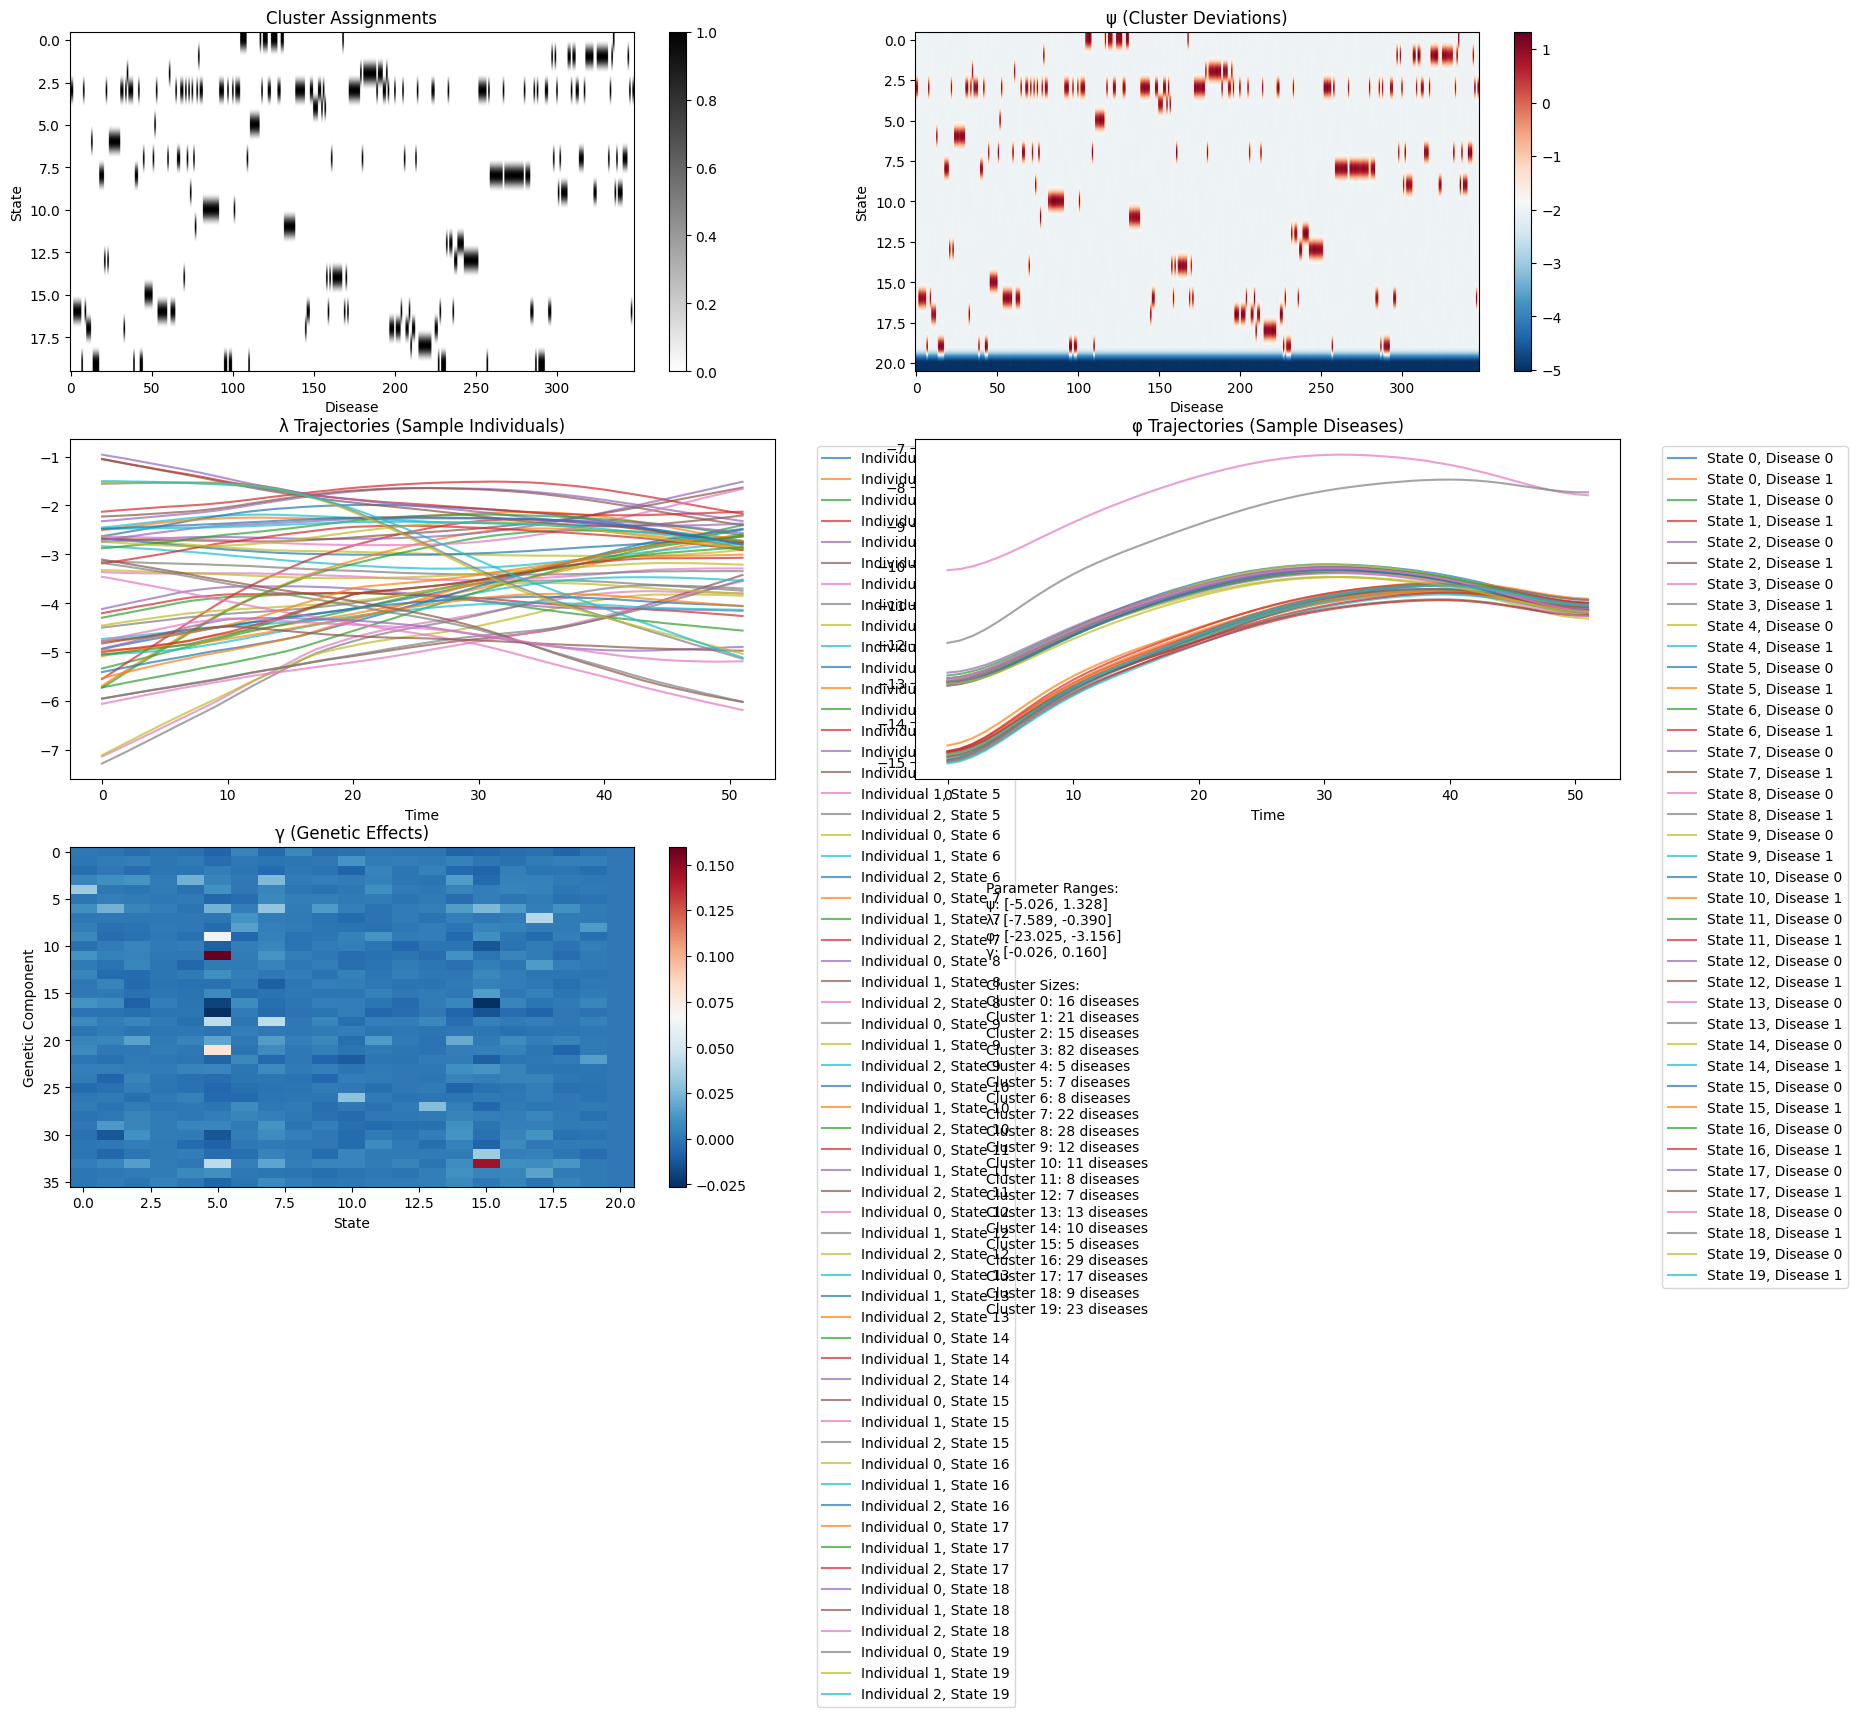

In [53]:
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y[:100000].shape[0], 
    D=Y[:100000].shape[1], 
    T=Y[:100000].shape[2], 
    K=20,
    P=G[:100000].shape[1],
    init_sd_scaler=1e-1,
    G=G[:100000], 
    Y=Y[:100000],
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters


import cProfile
import pstats
from pstats import SortKey

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')

model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

model.visualize_initialization()